## Simulación 1: 
En esta simulación se va a elaborar la simulación mostrada en las sección 6.

Este estudio sigue el enfoque de Kim y Tam (2021) y simula una población finita de tamaño $N = 1,000,000$ para evaluar distintos métodos de estimación. La variable de respuesta $y_i$ se genera mediante el modelo:

$$
y_i = 3 + 0.7(x_i - 2) + \eta_i
$$

donde $x_i \sim \mathcal{N}(2,1)$ y el error $\eta_i \sim \mathcal{N}(0,0.51)$ es independiente de $x_i$. Adicionalmente, se genera una versión contaminada de $y_i$, $\tilde{y}_i$, mediante:

$$
\tilde{y}_i = 2 + 0.9(y_i - 3) + \epsilon_i
$$

donde $\epsilon_i \sim \mathcal{N}(0, 0.5^2)$ y es independiente de $y_i$. Además, se generan variables auxiliares $\xi_i$ correlacionadas con $x_i$ que se utilizan para la calibración de los estimadores.

Se seleccionan dos muestras: una probabilística ($\mathcal{S}_A$, de tamaño $n_A = 1,000$) y otra no probabilística estratificada ($\mathcal{S}_B$, de tamaño $n_B = 500,000$). La muestra $\mathcal{S}_B$ se obtiene estratificando la población en dos grupos, basados en si $x_i \leq 2$ o $x_i > 2$, con 300,000 observaciones en el estrato 1 y 200,000 en el estrato 2.

El estudio considera dos escenarios:

1. **Escenario I**: Se observa $y_i$ en ambas muestras $\mathcal{S}_A$ y $\mathcal{S}_B$.
2. **Escenario II**: Se observa $y_i$ en $\mathcal{S}_A$ y la versión contaminada $\tilde{y}_i$ en $\mathcal{S}_B$.

Se consideran dos clases de estimadores: 

1. **Estimadores RegDI** (Integración de Datos por Regresión), que se calibran usando las siguientes restricciones para las variables auxiliares:

   - Para la calibración básica:

   $$
   \sum_{i \in \mathcal{S}_A} w_i^A (1, \delta_i, \delta_i y_i) = (N, n_B, Y_B^*)
   $$

   - Con las variables auxiliares $x_1$ y $x_2$:

   $$
   \sum_{i \in \mathcal{S}_A} w_i^A (1, \delta_i, \delta_i y_i, x_{1i}, x_{2i}) = (N, n_B, Y_B^*, X_1, X_2)
   $$

   - Con las variables auxiliares $\xi_1$ y $\xi_2$:

   $$
   \sum_{i \in \mathcal{S}_A} w_i^A (1, \delta_i, \delta_i y_i, \xi_{1i}, \xi_{2i}) = (N, n_B, Y_B^*, \Xi_1, \Xi_2)
   $$

2. **Estimadores de Pseudocalibración (PC)**, que se calibran con las siguientes ecuaciones:

   - Para las variables $x_1$ y $x_2$:

   $$
   \sum_{i \in \mathcal{S}_B} w_i^B (x_{1i}, x_{2i}) = (X_1, X_2)
   $$

   - Para las variables $\xi_1$ y $\xi_2$:

   $$
   \sum_{i \in \mathcal{S}_B} w_i^B (\xi_{1i}, \xi_{2i}) = (\Xi_1, \Xi_2)
   $$

En el **Escenario II**, se utiliza un estimador de pseudocalibración extendido, conocido como $\operatorname{PC}_{(X_1, X_2)}^D$, definido por:

$$
\hat{Y}_{PC}^{D} = \sum_{i \in \mathcal{S}_B} w_i^B \hat{\tilde{y}}_i + \sum_{i \in \mathcal{S}_A} d_i^A (y_i - \hat{y}_i)
$$

Este tipo de estimadores asegura que la distribución ponderada de la muestra no probabilística sea coherente con la distribución poblacional de las variables auxiliares.



### Generación de la población

In [5]:
library(survey)
library(dplyr)
library(ggplot2)
library(parallel)

Warning message:
"package 'survey' was built under R version 4.3.3"
Loading required package: grid

Loading required package: Matrix

Loading required package: survival

Warning message:
"package 'survival' was built under R version 4.3.2"

Attaching package: 'survey'


The following object is masked from 'package:graphics':

    dotchart



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
# Función para generar la población
generar_poblacion <- function(N, size_a, n_B1, n_B2, seed = NULL) {
  if (!is.null(seed)) {
    set.seed(seed)  # Asegurar reproducibilidad si se proporciona una semilla
  }
  
  # Generación de la población
  x_i <- rnorm(N, mean = 2, sd = 1)
  eta_i <- rnorm(N, mean = 0, sd = sqrt(0.51))
  y_i <- 3 + 0.7 * (x_i - 2) + eta_i
  
  # Generar la versión contaminada de y_i (tilde_y_i)
  tilde_y_i <- 2 + 0.9 * (y_i - 3) + rnorm(N, mean = 0, sd = 0.5)
  
  # Generar variables auxiliares e_i y las variables indicadoras e1_i y e2_i
  rho <- 0.5
  v_i <- rnorm(N, mean = 0, sd = 1)
  e_i <- rho * x_i + sqrt(1 - rho^2) * v_i  # Variable correlacionada
  e1_i <- ifelse(e_i <= 1, 1, 0)            # Variable indicadora e1_i
  e2_i <- ifelse(e_i > 1, 1, 0)             # Variable indicadora e2_i
  
  # Generar las variables auxiliares x1_i y x2_i
  x1_i <- ifelse(x_i <= 2, 1, 0) 
  x2_i <- ifelse(x_i > 2, 1, 0)
  
  # Crear data.frame de la población
  poblacion <- data.frame(
    id = 1:N,
    x_i = x_i,
    y_i = y_i,
    tilde_y_i = tilde_y_i,
    e_i = e_i,
    e1_i = e1_i,
    e2_i = e2_i,
    x1_i = x1_i,
    x2_i = x2_i
  )
  
  # Seleccionar muestra probabilística A (S_A) de tamaño 1000
  indices_A <- sample(1:N, size = size_a, replace = FALSE)
  poblacion$muestra_A <- 0
  poblacion$muestra_A[indices_A] <- 1
  
  # Seleccionar muestra no probabilística B (S_B) mediante estratificación
  stratum1 <- which(poblacion$x_i <= 2)
  stratum2 <- which(poblacion$x_i > 2)
  indices_B1 <- sample(stratum1, size = n_B1, replace = FALSE)
  indices_B2 <- sample(stratum2, size = n_B2, replace = FALSE)
  indices_B <- c(indices_B1, indices_B2)
  poblacion$muestra_B <- 0
  poblacion$muestra_B[indices_B] <- 1
  
  return(poblacion)
}

# Generar una sola población con los parámetros especificados
N <- 100000  # Tamaño de la población
size_a <- 1000  # Tamaño de la muestra probabilística A
n_B1 <- 30000  # Tamaño del estrato 1 de la muestra no probabilística B
n_B2 <- 20000  # Tamaño del estrato 2 de la muestra no probabilística B

# Generar la población
poblacion_generada <- generar_poblacion(N, size_a, n_B1, n_B2, seed = 1234)

# Visualizar un resumen de la población generada
summary(poblacion_generada)


       id              x_i              y_i           tilde_y_i     
 Min.   :     1   Min.   :-2.509   Min.   :-1.980   Min.   :-2.271  
 1st Qu.: 25001   1st Qu.: 1.329   1st Qu.: 2.329   1st Qu.: 1.306  
 Median : 50001   Median : 2.004   Median : 3.004   Median : 2.009  
 Mean   : 50001   Mean   : 2.003   Mean   : 3.004   Mean   : 2.005  
 3rd Qu.: 75000   3rd Qu.: 2.674   3rd Qu.: 3.672   3rd Qu.: 2.698  
 Max.   :100000   Max.   : 5.906   Max.   : 7.361   Max.   : 6.546  
      e_i               e1_i             e2_i             x1_i       
 Min.   :-3.2001   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.: 0.3245   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median : 1.0002   Median :0.0000   Median :1.0000   Median :0.0000  
 Mean   : 0.9997   Mean   :0.4999   Mean   :0.5001   Mean   :0.4983  
 3rd Qu.: 1.6725   3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   : 5.2789   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
      x2_i          muestra

### Simulación

In [7]:
source('PC.R')
source('RegDI2.R')

In [5]:
library(survey)

# Número de simulaciones Monte Carlo
n_sim <- 100

# Parámetros de la simulación
N <- 100000     # Tamaño de la población
size_a <- 1000  # Tamaño de la muestra probabilística A
n_B1 <- 30000    # Tamaño de la primera estratificación de la muestra B
n_B2 <- 20000    # Tamaño de la segunda estratificación de la muestra B
Y_true <- 3     # Valor verdadero de la media poblacional

# Inicializar listas para acumular las estimaciones de cada simulación
estimates_list <- list(
  Mean_S_A = numeric(n_sim),
  Mean_S_B = numeric(n_sim),
  RegDI = numeric(n_sim),
  RegDI_X1 = numeric(n_sim),
  RegDI_e1 = numeric(n_sim),
  PC_X1 = numeric(n_sim),
  PC_e1 = numeric(n_sim),
  RegDI_II = numeric(n_sim),
  RegDI_X1_II = numeric(n_sim),
  RegDI_e1_II = numeric(n_sim),
  PC_X1_II = numeric(n_sim),
  PC_e1_II = numeric(n_sim)
)

# Realizar la simulación Monte Carlo
for (sim in 1:n_sim) {
  
  # Generar la población
  poblacion <- generar_poblacion(N, size_a, n_B1, n_B2, seed = sim)
  
  # Calcular los estimadores para el Escenario I
  
  # Media de la muestra A
  design_A <- svydesign(ids = ~1, data = subset(poblacion, muestra_A == 1), weights = ~1)
  mean_S_A <- coef(svymean(~y_i, design_A))
  estimates_list$Mean_S_A[sim] <- mean_S_A
  
  # Media de la muestra B
  design_B <- svydesign(ids = ~1, data = subset(poblacion, muestra_B == 1), weights = ~1)
  mean_S_B <- coef(svymean(~y_i, design_B))
  estimates_list$Mean_S_B[sim] <- mean_S_B
  
  # RegDI sin variables auxiliares
  result_RegDI_I <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = NULL,
    N_total = N
  )
  estimates_list$RegDI[sim] <- result_RegDI_I$mean_RegDI
  
  # RegDI con x1_i
  result_RegDI_I_x1 <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i"),
    N_total = N
  )
  estimates_list$RegDI_X1[sim] <- result_RegDI_I_x1$mean_RegDI
  
  # RegDI con e1_i
  result_RegDI_I_e1 <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("e1_i"),
    N_total = N
  )
  estimates_list$RegDI_e1[sim] <- result_RegDI_I_e1$mean_RegDI
  
  # PC_Estimator con x1_i, x2_i
  result_PC_New_I_X1_X2 <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i", "x2_i"),
    N_total = N,
    weights_A = NULL,
    weights_B = NULL,
    scenario = 1,
    outcome_model = NULL,
    model_type = "normal",
    eval_model_performance = FALSE
  )
  estimates_list$PC_X1[sim] <- result_PC_New_I_X1_X2$estimator
  
  # PC_Estimator con e1_i, e2_i
  result_PC_New_I_e1_e2 <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("e1_i", "e2_i"),
    N_total = N,
    weights_A = NULL,
    weights_B = NULL,
    scenario = 1,
    outcome_model = NULL,
    model_type = "normal",
    eval_model_performance = FALSE
  )
  estimates_list$PC_e1[sim] <- result_PC_New_I_e1_e2$estimator
  
  # Repetir el cálculo para el Escenario II
  
  # RegDI sin variables auxiliares (tilde_y_i en B)
  result_RegDI_II <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "tilde_y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = NULL,
    N_total = N
  )
  estimates_list$RegDI_II[sim] <- result_RegDI_II$mean_RegDI
  
  # RegDI con x1_i (tilde_y_i en B)
  result_RegDI_II_x1 <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "tilde_y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i"),
    N_total = N
  )
  estimates_list$RegDI_X1_II[sim] <- result_RegDI_II_x1$mean_RegDI
  
  # RegDI con e1_i (tilde_y_i en B)
  result_RegDI_II_e1 <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "tilde_y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("e1_i"),
    N_total = N
  )
  estimates_list$RegDI_e1_II[sim] <- result_RegDI_II_e1$mean_RegDI
  
  # PC_Estimator con x1_i, x2_i (tilde_y_i en B)
  result_PC_New_II_X1_X2 <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i", "x2_i"),
    N_total = N,
    weights_A = NULL,
    weights_B = NULL,
    scenario = 2,
    outcome_model = "y_i ~ tilde_y_i",
    model_type = "normal",
    eval_model_performance = FALSE
  )
  estimates_list$PC_X1_II[sim] <- result_PC_New_II_X1_X2$estimator
  
  # PC_Estimator con e1_i, e2_i (tilde_y_i en B)
  result_PC_New_II_e1_e2 <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("e1_i", "e2_i"),
    N_total = N,
    weights_A = NULL,
    weights_B = NULL,
    scenario = 2,
    outcome_model = "y_i ~ tilde_y_i",
    model_type = "normal",
    eval_model_performance = FALSE
  )
  estimates_list$PC_e1_II[sim] <- result_PC_New_II_e1_e2$estimator
}

# Calcular el sesgo promedio
bias_avg <- sapply(estimates_list, function(estimates) mean(estimates - Y_true))

# Calcular el error estándar (desviación estándar de las estimaciones)
se_mc <- sapply(estimates_list, sd)

# Crear el dataframe final con los resultados de sesgo promedio y el error estándar
results_summary <- data.frame(
  Scenario = c(rep("I", 7), rep("II", 5)),  # 7 estimadores para el Escenario I, 5 para el Escenario II
  Estimator = c("Mean_S_A", "Mean_S_B", "RegDI", "RegDI_X1", "RegDI_e1", "PC_X1", "PC_e1",
                "RegDI", "RegDI_X1", "RegDI_e1", "PC_X1", "PC_e1"),
  Bias = round(c(bias_avg["Mean_S_A"], bias_avg["Mean_S_B"], bias_avg["RegDI"], bias_avg["RegDI_X1"], 
                 bias_avg["RegDI_e1"], bias_avg["PC_X1"], bias_avg["PC_e1"],
                 bias_avg["RegDI_II"], bias_avg["RegDI_X1_II"], bias_avg["RegDI_e1_II"],
                 bias_avg["PC_X1_II"], bias_avg["PC_e1_II"]), 3),
  SE = round(c(se_mc["Mean_S_A"], se_mc["Mean_S_B"], se_mc["RegDI"], se_mc["RegDI_X1"],
               se_mc["RegDI_e1"], se_mc["PC_X1"], se_mc["PC_e1"],
               se_mc["RegDI_II"], se_mc["RegDI_X1_II"], se_mc["RegDI_e1_II"],
               se_mc["PC_X1_II"], se_mc["PC_e1_II"]), 3)
)

# Mostrar el resumen final con sesgos y error estándar
results_summary

,Scenario,Estimator,Bias,SE
,<chr>,<chr>,<dbl>,<dbl>
Mean_S_A,I,Mean_S_A,0.002,0.030
Mean_S_B,I,Mean_S_B,-0.112,0.003
RegDI,I,RegDI,0.000,0.023
RegDI_X1,I,RegDI_X1,0.000,0.023
RegDI_e1,I,RegDI_e1,0.000,0.023
PC_X1,I,PC_X1,0.000,0.004
PC_e1,I,PC_e1,-0.094,0.003
RegDI_II,II,RegDI,0.001,0.027
RegDI_X1_II,II,RegDI_X1,0.001,0.026


## Simulación MAR

### Primer caso: Dificultad Fija

Esta simulación tiene como objetivo evaluar la robustez de varios métodos de estimación en un escenario en el que se viola el supuesto de Datos Faltantes Aleatorios (MAR). En este escenario, las probabilidades de inclusión en la muestra no probabilística dependen directamente de la variable de interés $y_i$, introduciendo un sesgo estructural que desafía los métodos de calibración tradicionales. Este sesgo es modelado usando una función logística parametrizada por $\gamma$.

**Modelo NMAR (Not Missing At Random)**

En el escenario NMAR, la probabilidad de que una unidad sea seleccionada en la muestra no probabilística ($\mathcal{S}_B$) depende directamente del valor de la variable de interés $y_i$. Específicamente, para cada individuo $i$, la probabilidad de ser incluido en la muestra $\mathcal{S}_B$ está dada por la siguiente función logística:

$$
\pi_B(y_i) = \frac{1}{1 + \exp(-\gamma(y_i - c))},
$$

donde $\gamma$ es un parámetro que controla la intensidad de la dependencia entre $y_i$ y la inclusión en $\mathcal{S}_B$. En esta simulación, probaremos diferentes valores de $\gamma$ en un rango de 0 a 1, lo que representa distintos niveles de violación del supuesto MAR. El parámetro $c$ se fija en 3 para centrar la función logística.

Se realizarán **100 simulaciones Monte Carlo** para evaluar el desempeño de los estimadores en función de distintos valores de $\gamma$ entre 0 y 1. Cada simulación generará una nueva población de tamaño $N = 100,000$, siguiendo el mismo modelo de regresión para la variable $y_i$ utilizado en el primer escenario, es decir:

$$
y_i = 3 + 0.7(x_i - 2) + \eta_i,
$$

donde $x_i \sim \mathcal{N}(2,1)$ y el término de error $\eta_i \sim \mathcal{N}(0,0.51)$ es independiente de $x_i$. Además, se generarán versiones contaminadas $\tilde{y}_i$ de $y_i$ para las observaciones en $\mathcal{S}_B$, según la ecuación:

$$
\tilde{y}_i = 2 + 0.9(y_i - 3) + \epsilon_i,
$$

donde $\epsilon_i \sim \mathcal{N}(0, 0.5^2)$ es independiente de $y_i$. 

Las simulaciones permiten evaluar el sesgo y la precisión de los estimadores en diferentes niveles de dependencia entre $y_i$ y la inclusión en $\mathcal{S}_B$, conforme se aumenta el valor de $\gamma$.

Los siguientes estimadores serán evaluados en este escenario NMAR:

1. **Estimador de la media usando la muestra probabilística** ($\mathcal{S}_A$): Este estimador se basa únicamente en la muestra probabilística y sirve como referencia.

2. **Estimador de la media usando la muestra no probabilística** ($\mathcal{S}_B$): Se calcula utilizando la muestra no probabilística sin ningún tipo de calibración.

3. **Estimadores de Pseudocalibración (PC):**
   
   Las ecuaciones de calibración en este caso se definen como:

   $$
   \sum_{i \in \mathcal{S}_B} w_i^B (x_{1i}, x_{2i}) = (X_1, X_2)
   $$
   y
   $$
   \sum_{i \in \mathcal{S}_B} w_i^B (e_{1i}, e_{2i}) = (E_1, E_2).
   $$

4. **Estimadores RegDI:**

   Las ecuaciones de calibración para estos estimadores son:

   $$
   \sum_{i \in \mathcal{S}_A} w_i^A (1, \delta_i, \delta_i y_i, x_{1i}, x_{2i}) = (N, n_B, Y_B^*, X_1, X_2)
   $$
   y
   $$
   \sum_{i \in \mathcal{S}_A} w_i^A (1, \delta_i, \delta_i y_i, e_{1i}, e_{2i}) = (N, n_B, Y_B^*, E_1, E_2).
   $$

**Métodos de Doble Robusto**

En escenarios donde el supuesto MAR no se cumple, se sugiere implementar **métodos de doble robusto**. Estos métodos combinan dos tipos de correcciones:

1. **Modelos de resultado:** Se ajusta un modelo de predicción de $y_i$ basado en las unidades observadas en $\mathcal{S}_A$ y $\mathcal{S}_B$.

2. **Corrección de calibración:** Los pesos de la muestra no probabilística se ajustan mediante calibración utilizando las variables auxiliares.

El estimador de doble robusto para pseudocalibración ($PC^D$), está definido en el artículo como:

$$
\hat{Y}_{PC}^{D} = \sum_{i \in \mathcal{S}_B} w_i^B \hat{\tilde{y}}_i + \sum_{i \in \mathcal{S}_A} d_i^A (y_i - \hat{y}_i),
$$

donde $\hat{y}_i$ es el valor predicho de $y_i$ y $\hat{\tilde{y}}_i$ es el valor ajustado en la muestra no probabilística. Este enfoque permite corregir los sesgos introducidos por la dependencia entre $y_i$ y la probabilidad de inclusión en $\mathcal{S}_B$.

El **estimador RegDI Doble Robusto** fue propuesto por el autor de este trabajo, y sigue un enfoque similar:

$$
\hat{Y}_{RegDI}^{D} = \sum_{i \in \mathcal{S}_A} w_i^A \hat{y}_i + \sum_{i \in \mathcal{S}_B} w_i^B (y_i - \hat{y}_i),
$$


In [8]:
source('PC.R')
source('RegDI2.R')

#### Generamos la población

In [9]:
# Función para generar población bajo NMAR
generate_population_NMAR <- function(N = 100000, size_a = 1000, size_muestra_B = 50000,
                                     gamma = 0.25, c = 3, seed_base = 1234, Fixed = TRUE) {
  set.seed(seed_base)  # Asegurar reproducibilidad
  x_i <- rnorm(N, mean = 2, sd = 1)
  eta_i <- rnorm(N, mean = 0, sd = sqrt(0.51))
  y_i <- 3 + 0.7 * (x_i - 2) + eta_i
  
  tilde_y_i <- 2 + 0.9 * (y_i - 3) + rnorm(N, mean = 0, sd = 0.5)
  
  rho <- 0.5
  v_i <- rnorm(N, mean = 0, sd = 1)
  e_i <- rho * x_i + sqrt(1 - rho^2) * v_i
  e1_i <- ifelse(e_i <= 1, 1, 0)
  e2_i <- ifelse(e_i > 1, 1, 0)
  
  x1_i <- ifelse(x_i <= 2, 1, 0)
  x2_i <- ifelse(x_i > 2, 1, 0)
  
  poblacion <- data.frame(
    id = 1:N,
    x_i = x_i,
    y_i = y_i,
    tilde_y_i = tilde_y_i,
    e_i = e_i,
    e1_i = e1_i,
    e2_i = e2_i,
    x1_i = x1_i,
    x2_i = x2_i
  )
  
  set.seed(seed_base + 1000)
  indices_A <- sample(1:N, size = size_a, replace = FALSE)
  poblacion$muestra_A <- 0
  poblacion$muestra_A[indices_A] <- 1
  
  prob_selection <- 1 / (1 + exp(-gamma * (poblacion$y_i - c)))
  
  set.seed(seed_base + 2000)
  if (Fixed) {
    prob_selection_normalized <- prob_selection / max(prob_selection)
    indices_B <- sample(1:N, size = size_muestra_B, replace = FALSE, prob = prob_selection_normalized)
  } else {
    indices_B <- which(runif(N) < prob_selection)
  }
  
  poblacion$muestra_B <- 0
  poblacion$muestra_B[indices_B] <- 1
  
  return(poblacion)
}


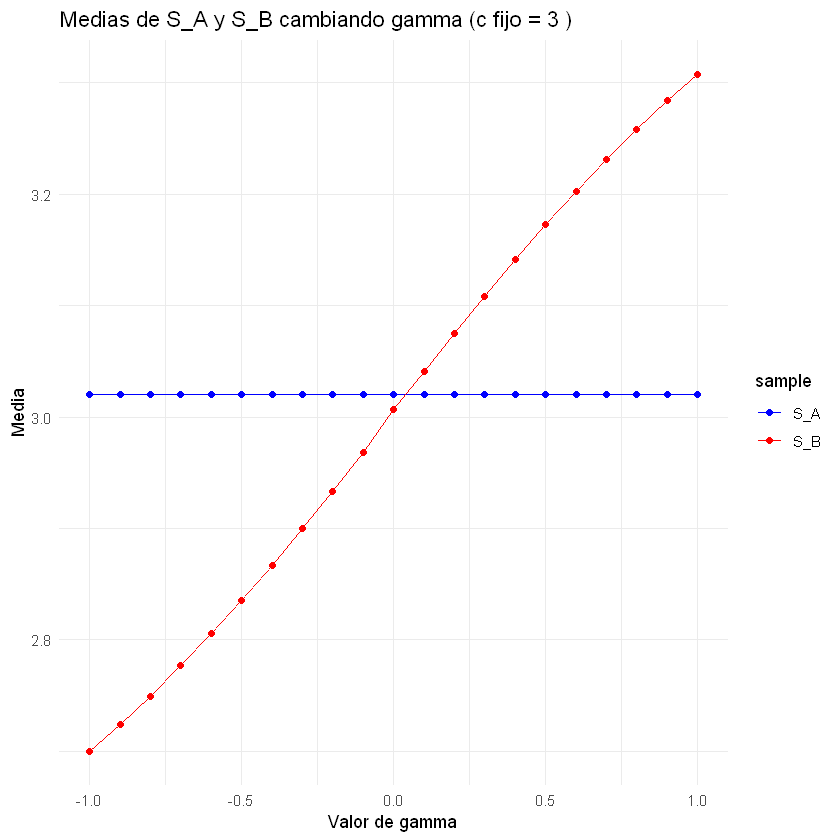

In [10]:
# Fijar un valor de c
c_value <- 3

# Definir los valores de gamma que queremos analizar
gamma_values <- seq(-1, 1, by = 0.10)

# Inicializar un dataframe para guardar los resultados
results_gamma <- data.frame(gamma_value = numeric(), sample = character(), media = numeric())
N = 100000

# Iterar sobre diferentes valores de gamma
for (gamma_value in gamma_values) {
  # Generar la población
  poblacion_NMAR <- generate_population_NMAR(N = N, size_a = 1000, size_muestra_B = 50000,
                                             gamma = gamma_value, c = c_value, seed_base = 1234)
  
  # Calcular la media observada en S_A
  mean_S_A <- mean(poblacion_NMAR$y_i[poblacion_NMAR$muestra_A == 1])
  
  # Calcular la media observada en S_B
  mean_S_B <- mean(poblacion_NMAR$y_i[poblacion_NMAR$muestra_B == 1])

  # Guardar los resultados
  results_gamma <- rbind(results_gamma, data.frame(gamma_value = gamma_value, sample = "S_A", media = mean_S_A))
  results_gamma <- rbind(results_gamma, data.frame(gamma_value = gamma_value, sample = "S_B", media = mean_S_B))
}

# Graficar las medias de S_A y S_B para diferentes valores de gamma
library(ggplot2)
ggplot(results_gamma, aes(x = gamma_value, y = media, color = sample)) +
  geom_line() +
  geom_point() +
  ggtitle(paste("Medias de S_A y S_B cambiando gamma (c fijo =", c_value, ")")) +
  xlab("Valor de gamma") +
  ylab("Media") +
  theme_minimal() +
  scale_color_manual(values = c("S_A" = "blue", "S_B" = "red"))

#### Unica iteración de prueba

In [11]:
# Simular la población
set.seed(42)
poblacion <- generate_population_NMAR(N = 100000, size_a = 1000, size_muestra_B = 50000, gamma = 0.25, c = 3)

# 1. Estimación de la media usando la muestra A
design_A <- svydesign(ids = ~1, data = subset(poblacion, muestra_A == 1), weights = ~1)
mean_S_A <- coef(svymean(~y_i, design_A))

# 2. Estimación de la media usando la muestra B
design_B <- svydesign(ids = ~1, data = subset(poblacion, muestra_B == 1), weights = ~1)
mean_S_B <- coef(svymean(~y_i, design_B))

# 3. PC usando x1_i y x2_i
result_PC_X1_X2 <- PC_Estimator(
  data = poblacion,
  y_A_col = "y_i",
  y_B_col = "y_i",
  ind_var_A = "muestra_A",
  ind_var_B = "muestra_B",
  aux_vars = c("x1_i", "x2_i"),
  N_total = nrow(poblacion),
  scenario = 1
)

# 4. PC usando e1_i y e2_i
result_PC_e1_e2 <- PC_Estimator(
  data = poblacion,
  y_A_col = "y_i",
  y_B_col = "y_i",
  ind_var_A = "muestra_A",
  ind_var_B = "muestra_B",
  aux_vars = c("e1_i", "e2_i"),
  N_total = nrow(poblacion),
  scenario = 1
)

# 5. RegDI usando x1_i
result_RegDI_X1 <- RegDI2(
  data = poblacion,
  y_A_col = "y_i",
  y_B_col = "y_i",
  ind_var_A = "muestra_A",
  ind_var_B = "muestra_B",
  aux_vars = c("x1_i"),
  N_total = nrow(poblacion)
)

# 6. RegDI usando e1_i
result_RegDI_e1 <- RegDI2(
  data = poblacion,
  y_A_col = "y_i",
  y_B_col = "y_i",
  ind_var_A = "muestra_A",
  ind_var_B = "muestra_B",
  aux_vars = c("e1_i"),
  N_total = nrow(poblacion)
)

# 7. PC usando x1_i y x2_i con un estimador doble robusto
result_PC_X1_X2_DR <- PC_Estimator(
  data = poblacion,
  y_A_col = "y_i",
  y_B_col = "y_i",
  ind_var_A = "muestra_A",
  ind_var_B = "muestra_B",
  aux_vars = c("x1_i", "x2_i"),
  N_total = nrow(poblacion),
  outcome_model = "y_i ~ x1_i + x2_i",
  model_type = "normal",
  scenario = 3
)

# 8. RegDI usando x1_i con un estimador doble robusto
result_RegDI_X1_DR <- RegDI2(
  data = poblacion,
  y_A_col = "y_i",
  y_B_col = "y_i",
  ind_var_A = "muestra_A",
  ind_var_B = "muestra_B",
  aux_vars = c("x1_i"),
  N_total = nrow(poblacion),
  outcome_model = "y_i ~ x1_i",
  correction = 3
)

# Imprimir resultados
cat("Media en muestra A:", mean_S_A, "\n")
cat("Media en muestra B:", mean_S_B, "\n")
cat("Estimador PC (x1_i, x2_i):", result_PC_X1_X2$estimator, "\n")
cat("Estimador PC (e1_i, e2_i):", result_PC_e1_e2$estimator, "\n")
cat("Estimador RegDI (x1_i):", result_RegDI_X1$mean_RegDI, "\n")
cat("Estimador RegDI (e1_i):", result_RegDI_e1$mean_RegDI, "\n")
cat("Estimador PC (Doble Robusto, x1_i, x2_i):", result_PC_X1_X2_DR$estimator_DR1, "\n")
cat("Estimador RegDI (Doble Robusto, x1_i):", result_RegDI_X1_DR$mean_RegDI, "\n")


Media en muestra A: 3.019955 
Media en muestra B: 3.091866 
Estimador PC (x1_i, x2_i): 3.06419 
Estimador PC (e1_i, e2_i): 3.08589 
Estimador RegDI (x1_i): 3.025545 
Estimador RegDI (e1_i): 3.025545 
Estimador PC (Doble Robusto, x1_i, x2_i): 3.06419 
Estimador RegDI (Doble Robusto, x1_i): 3.025014 


#### Simulación paralelizada

In [ ]:
# Cargar librerías necesarias
library(survey)
library(dplyr)
library(parallel)

# Definir el número de simulaciones por valor de gamma
n_sim <- 100

# Definir el vector de valores de gamma
gamma_values <- seq(0, 1, by = 0.1)

# Crear una lista para almacenar los resultados de todas las simulaciones
results_list <- list()

# Definir la función principal que se ejecutará en cada simulación
run_simulation <- function(gamma_value, sim_num) {
    
  # Generar la población
  poblacion <- generate_population_NMAR(N = 100000, size_a = 1000, size_muestra_B = 50000, gamma = gamma_value, c = 3, seed_base = sim_num)

  # 1. Estimación de la media usando la muestra A
  design_A <- svydesign(ids = ~1, data = subset(poblacion, muestra_A == 1), weights = ~1)
  mean_S_A <- coef(svymean(~y_i, design_A))

  # 2. Estimación de la media usando la muestra B
  design_B <- svydesign(ids = ~1, data = subset(poblacion, muestra_B == 1), weights = ~1)
  mean_S_B <- coef(svymean(~y_i, design_B))

  # 3. PC usando x1_i y x2_i
  result_PC_X1_X2 <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i", "x2_i"),
    N_total = nrow(poblacion),
    scenario = 1
  )

  # 4. PC usando e1_i y e2_i
  result_PC_e1_e2 <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("e1_i", "e2_i"),
    N_total = nrow(poblacion),
    scenario = 1
  )

  # 5. RegDI usando x1_i
  result_RegDI_X1 <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i"),
    N_total = nrow(poblacion)
  )

  # 6. RegDI usando e1_i
  result_RegDI_e1 <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("e1_i"),
    N_total = nrow(poblacion)
  )

  # 7. PC usando x1_i y x2_i con un estimador doble robusto
  result_PC_X1_X2_DR <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i", "x2_i"),
    N_total = nrow(poblacion),
    outcome_model = "y_i ~ x1_i + x2_i",
    model_type = "normal",
    scenario = 3,
    eval_model_performance = TRUE
  )

  # 8. RegDI usando x1_i con un estimador doble robusto
  result_RegDI_X1_DR <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i"),
    N_total = nrow(poblacion),
    outcome_model = "y_i ~ x1_i",
    correction = 3
  )

  # 9. RegDI usando x1_i con un estimador doble robusto
    result_PC_X_i_DR <- PC_Estimator(
        data = poblacion,
        y_A_col = "y_i",
        y_B_col = "y_i",
        ind_var_A = "muestra_A",
        ind_var_B = "muestra_B",
        aux_vars = c("x1_i", "x2_i"),
        N_total = nrow(poblacion),
        outcome_model = "y_i ~ x_i ",
        model_type = "normal",
        scenario = 3,
        eval_model_performance = TRUE
      )
    
  # Almacenar los resultados en un data.frame para esta simulación
  result_df <- data.frame(
    Simulacion = sim_num,
    Gamma = gamma_value,
    Media_S_A = mean_S_A,
    Media_S_B = mean_S_B,
    PC_X1_X2 = result_PC_X1_X2$estimator,
    PC_e1_e2 = result_PC_e1_e2$estimator,
    RegDI_X1 = result_RegDI_X1$mean_RegDI,
    RegDI_e1 = result_RegDI_e1$mean_RegDI,
    PC_X1_X2_DR = result_PC_X1_X2_DR$estimator_DR1,
    RegDI_X1_DR = result_RegDI_X1_DR$mean_RegDI
  )

  return(result_df)
}

# Usar paralelización para ejecutar las simulaciones de manera eficiente
cl <- makeCluster(detectCores() - 1)  # Detectar el número de núcleos y dejar uno libre
clusterEvalQ(cl, library(survey))  # Cargar librería survey en cada nodo del cluster
clusterExport(cl, c("generate_population_NMAR", "PC_Estimator", "RegDI2", "run_simulation"))  # Exportar funciones necesarias

# Iterar sobre los valores de gamma y ejecutar 100 simulaciones por valor
for (gamma_value in gamma_values) {
  # Exportar la variable `gamma_value` para cada iteración
  clusterExport(cl, "gamma_value")
  
  # Ejecutar simulaciones en paralelo para el valor de gamma actual
  sim_results <- parLapply(cl, 1:n_sim, function(sim_num) {
    run_simulation(gamma_value, sim_num)
  })
  
  # Convertir los resultados de la lista a un data.frame
  sim_results_df <- do.call(rbind, sim_results)
  
  # Almacenar los resultados en la lista general
  results_list[[as.character(gamma_value)]] <- sim_results_df
}

# Detener el cluster de paralelización
stopCluster(cl)

# Unir todos los resultados en un único data.frame
final_results <- do.call(rbind, results_list)

# Exportar los resultados a un archivo CSV
write.csv(final_results, "Resultados_simulacion_NMAR.csv", row.names = FALSE)

# Imprimir un mensaje indicando que la simulación ha finalizado
cat("Simulación completada. Los resultados se han guardado en 'Resultados_simulacion_NMAR.csv'.\n")


[[1]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[6]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[7]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"

In [ ]:
# Cargar las librerías necesarias
library(ggplot2)
library(reshape2)

# Paso 1: Calcular el sesgo
final_results$Bias_S_A <- final_results$Media_S_A - 3
final_results$Bias_S_B <- final_results$Media_S_B - 3
final_results$Bias_PC_X1_X2 <- final_results$PC_X1_X2 - 3
final_results$Bias_PC_e1_e2 <- final_results$PC_e1_e2 - 3
final_results$Bias_RegDI_X1 <- final_results$RegDI_X1 - 3
final_results$Bias_RegDI_e1 <- final_results$RegDI_e1 - 3
final_results$Bias_PC_X1_X2_DR <- final_results$PC_X1_X2_DR - 3
final_results$Bias_RegDI_X1_DR <- final_results$RegDI_X1_DR - 3

# Paso 2: Transformar el dataframe en formato largo para ggplot
final_results_long <- melt(final_results, id.vars = c("Simulacion", "Gamma"), 
                           measure.vars = c("Bias_S_A", "Bias_S_B", "Bias_PC_X1_X2", "Bias_PC_e1_e2", 
                                            "Bias_RegDI_X1", "Bias_RegDI_e1", "Bias_PC_X1_X2_DR", 
                                            "Bias_RegDI_X1_DR"),
                           variable.name = "Estimador", value.name = "Sesgo")

# Paso 3: Generar el gráfico de Sesgo vs Gamma para todos los estimadores
ggplot(final_results_long, aes(x = Gamma, y = Sesgo, color = Estimador)) +
  geom_line(stat = "summary", fun = mean, size = 1) +  # Mostrar la media del sesgo
  geom_point(stat = "summary", fun = mean, size = 2) +  # Añadir puntos para los valores promedio
  labs(title = "Sesgo vs Gamma para diferentes estimadores",
       x = "Valor de Gamma",
       y = "Sesgo (con respecto a la media real de 3)") +
  theme_minimal() +
  theme(legend.position = "right") +
  scale_color_brewer(palette = "Set1")  # Paleta de colores


### Nueva simulación. Caso: Variando la dificultad de predicción de yi

In [6]:
source('PC.R')
source('RegDI2.R')

#### Generación de la población

In [7]:
# Función para generar población bajo NMAR con múltiples variables objetivo y_i con diferentes SD en eta_i
generate_population_NMAR_v2 <- function(N = 100000, size_a = 1000, size_muestra_B = 50000,
                                        gamma = 0.25, c = 3, seed_base = 1234, sd_vector = c(0.5, 1, 2), Fixed = TRUE) {
  set.seed(seed_base)  # Asegurar reproducibilidad
  x_i <- rnorm(N, mean = 2, sd = 1)
  
  # Crear una lista para almacenar múltiples variables y_i con diferentes desviaciones estándar en eta_i
  y_list <- list()
  
  # Generar múltiples versiones de y_i con diferentes SD basadas en sd_vector que reemplazan a eta_i
  for (sd_value in sd_vector) {
    eta_i <- rnorm(N, mean = 0, sd = sd_value)  # Generar eta_i con la SD del vector
    y_i <- 3 + 0.7 * (x_i - 2) + eta_i  # Generar y_i con la eta_i ajustada por el sd_vector
    y_list[[paste0("y_i_sd_", sd_value)]] <- y_i  # Guardar con el nombre reflejando el valor de SD
  }

  # Crear las otras variables auxiliares como en la versión original
  rho <- 0.5
  v_i <- rnorm(N, mean = 0, sd = 1)
  e_i <- rho * x_i + sqrt(1 - rho^2) * v_i
  e1_i <- ifelse(e_i <= 1, 1, 0)
  e2_i <- ifelse(e_i > 1, 1, 0)
  
  x1_i <- ifelse(x_i <= 2, 1, 0)
  x2_i <- ifelse(x_i > 2, 1, 0)
  
  # Crear el dataframe de la población con las variables originales
  poblacion <- data.frame(
    id = 1:N,
    x_i = x_i,
    e_i = e_i,
    e1_i = e1_i,
    e2_i = e2_i,
    x1_i = x1_i,
    x2_i = x2_i
  )
  
  # Agregar las diferentes versiones de y_i al dataframe
  poblacion <- cbind(poblacion, do.call(cbind, y_list))
  
  # Generar las muestras A y B como en la versión original
  set.seed(seed_base + 1000)
  indices_A <- sample(1:N, size = size_a, replace = FALSE)
  poblacion$muestra_A <- 0
  poblacion$muestra_A[indices_A] <- 1
  
  # Usar la primera versión de y_i para calcular las probabilidades de selección de la muestra B
  prob_selection <- 1 / (1 + exp(-gamma * (poblacion[[paste0("y_i_sd_", sd_vector[1])]] - c)))

  set.seed(seed_base + 2000)
  if (Fixed) {
    prob_selection_normalized <- prob_selection / max(prob_selection)
    indices_B <- sample(1:N, size = size_muestra_B, replace = FALSE, prob = prob_selection_normalized)
  } else {
    indices_B <- which(runif(N) < prob_selection)
  }
  
  poblacion$muestra_B <- 0
  poblacion$muestra_B[indices_B] <- 1
  
  return(poblacion)
}

# Ejemplo de uso
set.seed(42)
poblacion_v2 <- generate_population_NMAR_v2(N = 100000, size_a = 1000, size_muestra_B = 50000, gamma = 0.25, c = 3, sd_vector = seq(0, 0.5, by = 0.125))


#### Una sola iteración de la función

In [18]:
calcular_sesgo_R2 <- function(poblacion, sd_vector) {
  resultados <- data.frame()  # Para almacenar los resultados

  for (sd_value in sd_vector) {
    y_col_name <- paste0("y_i_sd_", sd_value)  # Nombre de la columna de la respuesta
    
    # 1. PC Estimador Doble Robusto con auxiliares x_i
    result_PC_xi_DR <- PC_Estimator(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("x1_i", "x2_i"),
      N_total = nrow(poblacion),
      outcome_model = paste(y_col_name, "~ x1_i + x2_i"),
      model_type = "normal",
      scenario = 3,
      eval_model_performance = TRUE
    )

    # Calcular el sesgo
    sesgo_PC_xi_DR <- result_PC_xi_DR$estimator_DR1 - 3
    
    # 2. PC Estimador Doble Robusto con auxiliares e_i
    result_PC_ei_DR <- PC_Estimator(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("e1_i", "e2_i"),
      N_total = nrow(poblacion),
      outcome_model = paste(y_col_name, "~ e1_i + e2_i"),
      model_type = "normal",
      scenario = 3,
      eval_model_performance = TRUE
    )
    
    # Calcular el sesgo
    sesgo_PC_ei_DR <- result_PC_ei_DR$estimator_DR1 - 3
    
    # 3. RegDI Estimador con auxiliares x_i
    result_RegDI_xi <- RegDI2(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("x1_i"),
      N_total = nrow(poblacion),
      correction = 0
    )
    
    # Calcular el sesgo
    sesgo_RegDI_xi <- result_RegDI_xi$mean_RegDI - 3
    
    # 4. RegDI Estimador con auxiliares e_i
    result_RegDI_ei <- RegDI2(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("e1_i"),
      N_total = nrow(poblacion),
      correction = 0
    )
    
    # Calcular el sesgo
    sesgo_RegDI_ei <- result_RegDI_ei$mean_RegDI - 3
    
    # Crear un dataframe temporal para los resultados
    resultado_temp <- data.frame(
      y_col_name = y_col_name,
      sesgo_PC_xi_DR = sesgo_PC_xi_DR,
      sesgo_PC_ei_DR = sesgo_PC_ei_DR,
      sesgo_RegDI_xi = sesgo_RegDI_xi,
      sesgo_RegDI_ei = sesgo_RegDI_ei
    )
    
    # Incluir R2 solo si está disponible
    if (!is.null(result_PC_xi_DR$R2)) {
      resultado_temp$R2_PC_xi_DR <- result_PC_xi_DR$R2
    }
    
    if (!is.null(result_PC_ei_DR$R2)) {
      resultado_temp$R2_PC_ei_DR <- result_PC_ei_DR$R2
    }
    
    # Agregar los resultados al dataframe final
    resultados <- rbind(resultados, resultado_temp)
  }
  
  return(resultados)
}

# Ejecutar la función sobre la población generada
resultados_sesgo_R2 <- calcular_sesgo_R2(poblacion_v2, seq(0, 0.5, by = 0.125))

# Mostrar los resultados finales
print(resultados_sesgo_R2)


    y_col_name sesgo_PC_xi_DR sesgo_PC_ei_DR sesgo_RegDI_xi sesgo_RegDI_ei
1     y_i_sd_0     0.01910410     0.03852597   -0.006842100   -0.006842100
2 y_i_sd_0.125     0.01913386     0.03853612   -0.002469577   -0.002469577
3  y_i_sd_0.25     0.01818532     0.03764634    0.007738554    0.007738554
4 y_i_sd_0.375     0.01932200     0.03864912   -0.001286205   -0.001286205
5   y_i_sd_0.5     0.01779191     0.03714109    0.002239005    0.002239005
  R2_PC_xi_DR R2_PC_ei_DR
1   0.6236619   0.1663738
2   0.6087440   0.1582663
3   0.5503002   0.1514090
4   0.4656675   0.1113336
5   0.4455673   0.1028459


#### Simulación completa

In [ ]:
library(survey)
library(dplyr)
library(parallel)

# Definir el número de simulaciones por valor de gamma
n_sim <- 100

# Definir el vector de valores de gamma
gamma_values <- seq(0, 1, by = 0.1)

# Definir el vector de desviaciones estándar para y_i
sd_vector <- seq(0, 0.5, by = 0.125)

# Crear una lista para almacenar los resultados de todas las simulaciones
results_list <- list()

# Función para ejecutar una simulación por valor de gamma
run_simulation <- function(gamma_value, sim_num) {
  
  # Generar la población con los diferentes valores de gamma y sd_vector
  poblacion <- generate_population_NMAR_v2(N = 100000, size_a = 1000, size_muestra_B = 50000, gamma = gamma_value, c = 3, seed_base = sim_num, sd_vector = sd_vector)
  
  result_row <- data.frame(Simulacion = sim_num, Gamma = gamma_value)  # Inicializar una fila de resultados
  
  # Iterar sobre cada desviación estándar de la variable objetivo y_i
  for (sd_value in sd_vector) {
    y_col_name <- paste0("y_i_sd_", sd_value)  # Nombre de la columna de la respuesta
    
    # 1. PC Estimador Doble Robusto con variables auxiliares x_i
    result_PC_xi_DR <- PC_Estimator(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("x1_i", "x2_i"),
      N_total = nrow(poblacion),
      outcome_model = paste(y_col_name, "~ x1_i + x2_i"),
      model_type = "normal",
      scenario = 3,
      eval_model_performance = TRUE
    )
    
    # 2. PC Estimador Doble Robusto con variables auxiliares e_i
    result_PC_ei_DR <- PC_Estimator(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("e1_i", "e2_i"),
      N_total = nrow(poblacion),
      outcome_model = paste(y_col_name, "~ e1_i + e2_i"),
      model_type = "normal",
      scenario = 3,
      eval_model_performance = TRUE
    )
    
    # 3. RegDI sin auxiliares
    result_RegDI_no_aux <- RegDI2(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      N_total = nrow(poblacion),
      correction = 0
    )
    
    # 4. RegDI con auxiliares x_i
    result_RegDI_xi <- RegDI2(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("x1_i"),
      N_total = nrow(poblacion),
      correction = 1
    )
    
    # 5. RegDI con auxiliares e_i
    result_RegDI_ei <- RegDI2(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("e1_i"),
      N_total = nrow(poblacion),
      correction = 1
    )
    
    # Agregar los resultados de cada estimador y desviación estándar a la fila de resultados
    result_row[paste0("mean_PC_xi_DR_", y_col_name)] <- result_PC_xi_DR$estimator_DR1
    result_row[paste0("mean_PC_ei_DR_", y_col_name)] <- result_PC_ei_DR$estimator_DR1
    result_row[paste0("mean_RegDI_no_aux_", y_col_name)] <- result_RegDI_no_aux$mean_RegDI
    result_row[paste0("mean_RegDI_xi_", y_col_name)] <- result_RegDI_xi$mean_RegDI
    result_row[paste0("mean_RegDI_ei_", y_col_name)] <- result_RegDI_ei$mean_RegDI
    
    # Incluir R2 si está disponible
    if (!is.null(result_PC_xi_DR$R2)) {
      result_row[paste0("R2_PC_xi_DR_", y_col_name)] <- result_PC_xi_DR$R2
    }
    if (!is.null(result_PC_ei_DR$R2)) {
      result_row[paste0("R2_PC_ei_DR_", y_col_name)] <- result_PC_ei_DR$R2
    }
  }
  
  return(result_row)
}

# Usar paralelización para ejecutar las simulaciones de manera eficiente
cl <- makeCluster(detectCores() - 1)  # Detectar el número de núcleos y dejar uno libre
clusterEvalQ(cl, library(survey))  # Cargar librería survey en cada nodo del cluster
clusterExport(cl, c("generate_population_NMAR_v2", "PC_Estimator", "RegDI2", "run_simulation", "sd_vector"))  # Exportar funciones necesarias

# Iterar sobre los valores de gamma y ejecutar simulaciones por valor
for (gamma_value in gamma_values) {
  clusterExport(cl, "gamma_value")
  
  # Ejecutar simulaciones en paralelo para el valor de gamma actual
  sim_results <- parLapply(cl, 1:n_sim, function(sim_num) {
    run_simulation(gamma_value, sim_num)
  })
  
  # Convertir los resultados de la lista a un data.frame
  sim_results_df <- do.call(rbind, sim_results)
  
  # Almacenar los resultados en la lista general
  results_list[[as.character(gamma_value)]] <- sim_results_df
}

# Detener el cluster de paralelización
stopCluster(cl)

# Unir todos los resultados en un único data.frame
final_results <- do.call(rbind, results_list)

# Exportar los resultados a un archivo CSV
write.csv(final_results, "Resultados_simulacion_NMAR_v2.csv", row.names = FALSE)

# Imprimir un mensaje indicando que la simulación ha finalizado
cat("Simulación completada. Los resultados se han guardado en 'Resultados_simulacion_NMAR_v2.csv'.\n")


[[1]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[6]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[7]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"